# **Финальная версия: замороженные веса BERT**

# **Бейзлайн 1: BERT (без головы)**

**BERT (и другие модели из библиотеки Hugging Face) состоит из двух частей:**

**Base Model (основа):** Это часть модели, которая генерирует эмбеддинги (векторные представления) для входных токенов.

**Head (голова):** Это дополнительный слой, который используется для конкретной задачи (например, классификация, NER, маскирование токенов и т.д.).

In [1]:
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00


In [2]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, TrainingArguments, Trainer

# AutoModelForTokenClassification загружает BERT с головой для задачи классификации токенов (Token Classification), вместо него использую просто AutoModel

import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
import torch
import evaluate
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import csv

In [3]:
import evaluate
! pip install seqeval
metric = evaluate.load('seqeval')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=5a28feb47dccc5e70667caf0ea9ba0d96099f320d007442dae2a4f81dca0a4d0
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
from transformers import EarlyStoppingCallback

In [5]:
!pip install tabulate
from tabulate import tabulate

In [6]:
import seaborn as sns
from collections import Counter
import numpy as np

In [49]:
import os
os.environ['WANDB_DISABLED'] = 'true'

In [50]:
# Чтение .csv файла для проверки
filepath = pd.read_csv('/content/Multilingual-dataset.csv')
filepath.head(5)

,text,NER
0,Детство,O
1,провёл,O
2,в,O
3,Надьсомбате,B-LOC
4,с,O


# **Попытка 3**

**Функция для распарсивания датасета**

In [52]:
def parse_dataset(filepath): # (перекопировала, как было в прошлый раз)
    sentences, labels = [], []
    with open(filepath, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        current_sentence, current_labels = [], []
        for row in reader:
            if not row or row[0] == '':  # пустая строка или строка с пустым токеном - конец предложения
                if current_sentence:
                    sentences.append(current_sentence)
                    labels.append(current_labels)
                current_sentence, current_labels = [], []
            else:
                token, tag = row[0], row[1]  # токен и метка находятся в первых двух колонках
                current_sentence.append(token)
                current_labels.append(tag)
        # добавляю последнее предложение на случай, если файл не заканчивался на пустую строчку
        if current_sentence:
            sentences.append(current_sentence)
            labels.append(current_labels)
    return sentences, labels

# Проверка данных
sentences, labels = parse_dataset('/content/Multilingual-dataset.csv')

In [53]:
# Проверю количество предложений, примеры предложений и меток
print(f"Количество предложений: {len(sentences)}")
print(f"Пример предложения: {sentences[0]}")
print(f"Пример меток: {labels[0]}")

Количество предложений: 3833
Пример предложения: ['text', 'Детство', 'провёл', 'в', 'Надьсомбате', 'с', '1860', 'г', '.']
Пример меток: ['NER', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O']


**Распределение меток (классов NER)**

<ipython-input-11-1d21fe161e83>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels_order, y=counts, palette="viridis")


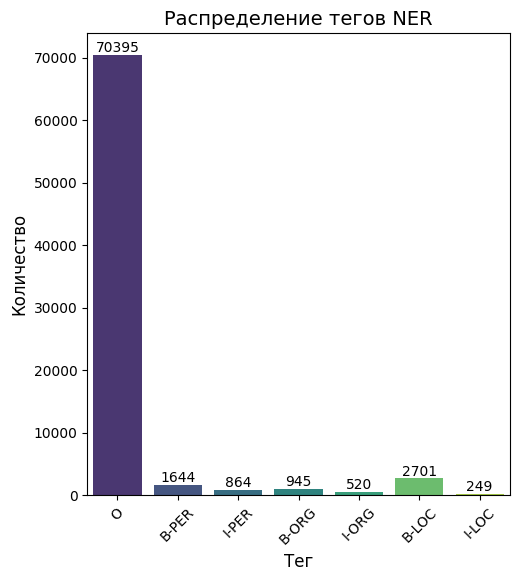

In [ ]:
# визуализирую распределенин меток
all_labels = [label for sublist in labels for label in sublist] # собираю метки в один список
label_counts = Counter(all_labels) # считается частотность
labels_order = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC"]
counts = [label_counts[label] for label in labels_order]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
ax = sns.barplot(x=labels_order, y=counts, palette="viridis")
plt.title("Распределение тегов NER", fontsize=14)
plt.xlabel("Тег", fontsize=12)
plt.ylabel("Количество", fontsize=12)
plt.xticks(rotation=45)
# Добавлю значение и столбцы
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=10, color='black',
                xytext=(0, 5),
                textcoords='offset points')

In [54]:
# Разделю данные на тренировочные и валидационные
from sklearn.model_selection import train_test_split
# Первое разделение: тренировачные данные 70% + остальное - 30%
train_sentences, temp_sentences, train_labels, temp_labels = train_test_split(
    sentences, labels, test_size=0.3, random_state=42
)
# Второе разделение: валидационные - 20% и тестовые - 10%, всего temp = 30, test_size=0.333, т.к 10/30
val_sentences, test_sentences, val_labels, test_labels = train_test_split(
    temp_sentences, temp_labels, test_size=0.333, random_state=42
)

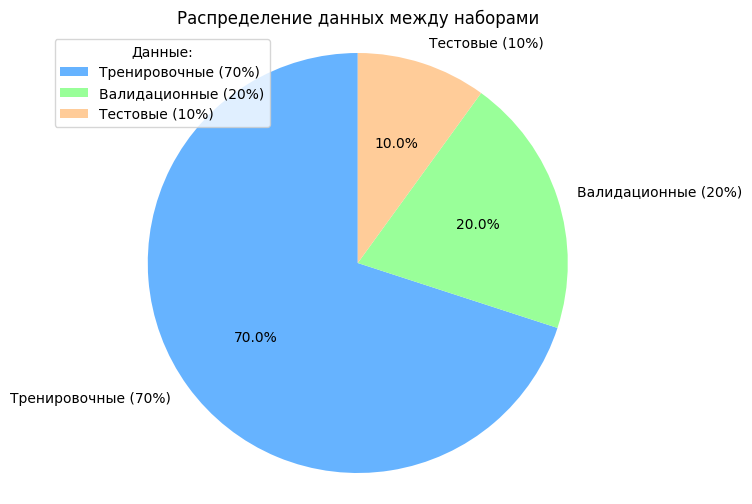

In [ ]:
# хочу визуализировать данные
train_size = len(train_sentences)
val_size = len(val_sentences)
test_size = len(test_sentences)

sizes = [train_size, val_size, test_size]
labels = ['Тренировочные (70%)', 'Валидационные (20%)', 'Тестовые (10%)']
colors = ['#66b3ff', '#99ff99', '#ffcc99']
# пусть будет круговая диаграмма
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Распределение данных между наборами')
plt.axis('equal')
plt.legend(title="Данные:", loc="upper left")
plt.show()

In [56]:
# определю теги и их ID
labels = {'I-ORG': 1,
            'B-LOC': 2,
            'B-ORG': 3,
            'I-LOC': 4,
            'I-PER': 5,
            'O': 6,
            'B-PER': 7}
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}

In [57]:
labels

{'I-ORG': 1,
 'B-LOC': 2,
 'B-ORG': 3,
 'I-LOC': 4,
 'I-PER': 5,
 'O': 6,
 'B-PER': 7}

**Загрузка токенизатора и модели**

In [58]:
# загружаю токенизатор и модель BERT без головы
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased")

In [59]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [60]:
# класс NERDataset для обработки данных(копия из семинара NER):
class NERDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, label2id, max_length=128):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.label2id = label2id # cловарь для преобразования меток в числовые ID
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.sentences[idx]
        tags = self.labels[idx]

        # здесь происходит токенизация
        encoding = self.tokenizer(
            tokens,
            is_split_into_words=True,
            padding='max_length',
            truncation=True, # обрезает последовательность, если она длиннее max_length
            max_length=self.max_length,
            return_offsets_mapping=True
        )

        # связываю метоки с токенами
        labels = []
        word_ids = encoding.word_ids()
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:  # специальные токены или паддинг
                labels.append(-100)
            elif word_id != previous_word_id:  # начало нового слова
                labels.append(self.label2id.get(tags[word_id], -100))
            else:  # подтокены
                labels.append(-100)
            previous_word_id = word_id

        encoding["labels"] = labels
        encoding.pop("offset_mapping")  # Удаляю offset_mapping, так как он не нужен

        return {key: torch.tensor(val) for key, val in encoding.items()} #  возвращает словарь с ключами: input_ids, attention_mask, labels

In [61]:
def create_dataloader(sentences, labels, tokenizer, label2id, batch_size=64, max_length=128, shuffle=True):
    dataset = NERDataset(sentences, labels, tokenizer, label2id, max_length=max_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [62]:
train_dataloader = create_dataloader(train_sentences, train_labels, tokenizer, label2id, shuffle=True)
val_dataloader = create_dataloader(val_sentences, val_labels, tokenizer, label2id, shuffle=True)
test_dataloader = create_dataloader(test_sentences, test_labels, tokenizer, label2id, shuffle=False)

In [63]:
train_dataset = NERDataset(train_sentences, train_labels, tokenizer, label2id)
val_dataset = NERDataset(val_sentences, val_labels, tokenizer, label2id)
test_dataset = NERDataset(test_sentences, test_labels, tokenizer, label2id)

In [64]:
from sklearn.utils.class_weight import compute_class_weight

In [65]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

**Фиксация seed для воспроизводимости результатов**

In [66]:
import random
import os
# Фиксирую seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# для обеспечения детерминизма в операциях на GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [67]:
#  модель на GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [68]:
class NERModel_4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.bert = AutoModel.from_pretrained("bert-base-multilingual-cased")
        self.num_labels = num_classes
        self.dropout = nn.Dropout(0.2)

        # Кастомная голова
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 768),
            nn.LayerNorm(768),
            nn.GELU(),
            nn.Dropout(0.2),

            nn.Linear(768, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.2),

            nn.Linear(128, num_classes)
        )

        # на первых эпохах он заморожен, потом же будет постепенно размораживаться
        for param in self.bert.parameters():
            param.requires_grad = False


    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        # градиенты будут вычисляться только для размороженных параметров
        with torch.set_grad_enabled(any(p.requires_grad for p in self.bert.parameters())):
            outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

        sequence_output = self.dropout(outputs.last_hidden_state)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(
                ignore_index=-100
            )
            loss = loss_fn(
                logits.view(-1, self.num_labels),
                labels.view(-1)
            )

        return (loss, logits) if loss is not None else logits

In [69]:
# Инициализация модели
model = NERModel_4(num_classes=len(labels))
model.to(device)

NERModel_4(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [70]:
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics(p):
    predictions, labels = p

    # Преобразование логитов в предсказанные классы
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for prediction, label_seq in zip(predictions, labels):
        current_predictions = []
        current_labels = []

        for pred, lab in zip(prediction, label_seq):
            if lab != -100:
                current_predictions.append(id2label[pred])
                current_labels.append(id2label[lab])

        if current_predictions:
            true_predictions.append(current_predictions)
            true_labels.append(current_labels)

    if not true_predictions:
        return {"precision": 0, "recall": 0, "f1": 0, "accuracy": 0}

    # Вычисление метрик
    precision = precision_score(true_labels, true_predictions, zero_division=0)
    recall = recall_score(true_labels, true_predictions, zero_division=0)
    f1 = f1_score(true_labels, true_predictions, zero_division=0)
    accuracy = accuracy_score(true_labels, true_predictions)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

In [71]:
encoder_lr = 1e-5  # lr для энкодера
classifier_lr = 1e-3  # lr для головы

optimizer = AdamW([
    {'params': model.classifier.parameters(), 'lr': classifier_lr},
    {'params': model.bert.parameters(), 'lr': encoder_lr}
], amsgrad=True)

In [ ]:
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [74]:
from transformers import TrainerCallback, TrainerState, TrainerControl
class UnfreezeCallback(TrainerCallback):
    def __init__(self, encoder, unfreeze_epoch=2, layers_per_epoch=1):
        self.encoder = encoder
        self.unfreeze_epoch = unfreeze_epoch
        self.encoder_lr = encoder_lr
        self.layers_per_epoch = layers_per_epoch
        self.frozen_layers = [layer for layer in reversed(encoder.encoder.layer)] # Исправила: теперь слои BERT должны размораживаться от 12 к 1
        # self.frozen_layers = [layer for layer in encoder.encoder.layer]  Было: все слои BERT размораживались от 1 к 12
        self.current_unfrozen = 0

    def on_epoch_begin(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        if state.epoch >= self.unfreeze_epoch and self.current_unfrozen < len(self.frozen_layers):
            # разморозка слоев
            for layer in self.frozen_layers[self.current_unfrozen : self.current_unfrozen + self.layers_per_epoch]:
                for param in layer.parameters():
                    param.requires_grad = True

            self.current_unfrozen += self.layers_per_epoch
            #print(f"Unfrozen {self.current_unfrozen} BERT layers at epoch {int(state.epoch)+1}")

In [75]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=20,
    weight_decay=0.05,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1")

In [76]:
from transformers import get_linear_schedule_with_warmup
total_steps = len(train_dataloader) * training_args.num_train_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)

In [77]:
trainer = Trainer(
    model=model,
    args=training_args,
    optimizers=(optimizer, scheduler),
    train_dataset=train_dataloader.dataset,
    eval_dataset=val_dataloader.dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=5),
        UnfreezeCallback(
            encoder=model.bert,  # передаю сам энкодер, его слои будут постепенно размораживаться
            unfreeze_epoch=2, layers_per_epoch=1)
    ]
)
# unfreeze_epoch=25 - это номер эпохи, с которой начинается разморозка
# layers_per_epoch=1 - rоличество слоёв, которые размораживаются за одну эпоху

<ipython-input-77-fc3e4e96088f>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [78]:
# Обучение модели
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.211500,0.142902,0.475177,0.599404,0.530110,0.955827
2,0.128000,0.095069,0.668712,0.758449,0.710759,0.970210
3,0.115900,0.087046,0.709818,0.812127,0.757534,0.972320
4,0.099000,0.078496,0.729947,0.814115,0.769737,0.973982
5,0.084700,0.081600,0.719492,0.843936,0.776761,0.973726
6,0.065800,0.074710,0.759494,0.834990,0.795455,0.976859
7,0.062800,0.075591,0.756804,0.856859,0.803730,0.976092
8,0.058200,0.074709,0.777677,0.851889,0.813093,0.976667
9,0.045900,0.071258,0.775785,0.859841,0.815653,0.976603
10,0.041300,0.071825,0.804554,0.842942,0.823301,0.977881


TrainOutput(global_step=840, training_loss=0.06524804594616095, metrics={'train_runtime': 1200.9977, 'train_samples_per_second': 44.68, 'train_steps_per_second': 0.699, 'total_flos': 0.0, 'train_loss': 0.06524804594616095, 'epoch': 20.0})

In [ ]:
# unfreeze_epoch=2 - это номер эпохи, с которой начинается разморозка
# layers_per_epoch=1 - rоличество слоёв, которые размораживаются за одну эпоху

In [79]:
# посмотрю метрики на валидационной части
val_metrics = trainer.evaluate(eval_dataset=val_dataset)

In [80]:
metrics_data = [
    ["Loss", val_metrics['eval_loss'], f"{val_metrics['eval_loss']:.4f}"],
    ["Precision", val_metrics['eval_precision'], f"{val_metrics['eval_precision']*100:.1f}%"],
    ["Recall", val_metrics['eval_recall'], f"{val_metrics['eval_recall']*100:.1f}%"],
    ["F1", val_metrics['eval_f1'], f"{val_metrics['eval_f1']*100:.1f}%"],
    ["Accuracy", val_metrics['eval_accuracy'], f"{val_metrics['eval_accuracy']*100:.1f}%"]
]

# Вывод таблицы
print("\n" + tabulate(metrics_data,
                    headers=["Metric", "Value", "Percentage"],
                    tablefmt="grid",
                    floatfmt=".4f"))


+-----------+---------+--------------+
| Metric    |   Value | Percentage   |
+===========+=========+==============+
| Loss      |  0.0800 | 0.0800       |
+-----------+---------+--------------+
| Precision |  0.8007 | 80.1%        |
+-----------+---------+--------------+
| Recall    |  0.8668 | 86.7%        |
+-----------+---------+--------------+
| F1        |  0.8325 | 83.2%        |
+-----------+---------+--------------+
| Accuracy  |  0.9788 | 97.9%        |
+-----------+---------+--------------+


In [81]:
def predict(sentence, tokenizer, model, device='cuda'): #(скопировала код из тетрадки)
    model.to(device)
    model.eval()  # переводим модель в режим оценки

    # Токенизация предложения
    tokens = tokenizer(
        sentence.split(),  # Разделяю предложение на слова
        is_split_into_words=True,  # Указываю, что вход уже разделен на слова
        return_tensors="pt",  # Возвращаю тензоры PyTorch
        truncation=True,  # Обрезаю предложение, если оно длиннее максимальной длины
        padding=True,  # Добавляю паддинг, если предложение короче максимальной длины
    )

    #  индексы слов для каждого токена
    word_ids = tokens.word_ids()

    # входные данные на устройство
    tokens = {key: val.to(device) for key, val in tokens.items()}

    # предсказание
    with torch.no_grad():
        outputs = model(**tokens)  # Прямой проход через модель
        logits = outputs[1] if isinstance(outputs, tuple) else outputs  #  logits
        predictions = logits.argmax(dim=-1).squeeze().tolist()  # logits в предсказания

    # Сопоставляю предсказания с исходными словами
    aligned_predictions = []
    current_word_id = None

    for word_id, prediction in zip(word_ids, predictions):
        if word_id is not None and word_id != current_word_id:  # начало нового слова
            aligned_predictions.append(id2label[prediction])  #  ID в метку
            current_word_id = word_id

    # Соединяю слова и их предсказанные метки
    result = list(zip(sentence.split(), aligned_predictions))
    return result

In [82]:
# Проверка на различных примерах
test_sentences = [
    "Окончил в 1966 году школу в Бронксе.",
    "Сергей Иванов работает в Google в Москве.",
    "Президент Франции Эммануэль Макрон посетил Берлин.",
    "Доктор Петрова из МГУ опубликовала новое исследование.",
    "Александр Пушкин родился в Москве в 1799 году.",
    "Компания Яндекс открыла новый офис в Казани.",
    "Мы летим в Нью-Йорк рейсом Аэрофлота SU-100.",
    "Профессор Смирнов и доцент Кузнецова участвовали в конференции в Санкт-Петербурге.",
    "Турнир по теннису Ролан Гаррос проходит в Париже.",
    "Директор Microsoft Сатья Наделла выступил на форуме в Сиэтле.",
    "Вчера видел Илон Маска в кафе Starbucks на Тверской.",
    "Картину Ван Гога купил музей Эрмитаж за 10 миллионов долларов."
]

print("="*50)
print("ТЕСТИРОВАНИЕ МОДЕЛИ NER")
print("="*50)

for sent in test_sentences:
    print("\nПредложение:", sent)
    predictions = predict(sent, tokenizer, model)
    print("Результаты:")
    for word, label in predictions:
        print(f"{word}: {label}")
    print("-"*50)

ТЕСТИРОВАНИЕ МОДЕЛИ NER

Предложение: Окончил в 1966 году школу в Бронксе.
Результаты:
Окончил: O
в: O
1966: O
году: O
школу: O
в: O
Бронксе.: B-LOC
--------------------------------------------------

Предложение: Сергей Иванов работает в Google в Москве.
Результаты:
Сергей: B-PER
Иванов: I-PER
работает: O
в: O
Google: B-LOC
в: O
Москве.: B-LOC
--------------------------------------------------

Предложение: Президент Франции Эммануэль Макрон посетил Берлин.
Результаты:
Президент: O
Франции: B-LOC
Эммануэль: B-PER
Макрон: I-PER
посетил: O
Берлин.: B-LOC
--------------------------------------------------

Предложение: Доктор Петрова из МГУ опубликовала новое исследование.
Результаты:
Доктор: O
Петрова: B-PER
из: O
МГУ: B-ORG
опубликовала: O
новое: O
исследование.: O
--------------------------------------------------

Предложение: Александр Пушкин родился в Москве в 1799 году.
Результаты:
Александр: B-PER
Пушкин: I-PER
родился: O
в: O
Москве: B-LOC
в: O
1799: O
году.: O
-----------------

In [83]:
from tabulate import tabulate
from termcolor import colored

def get_colored_label(label):
    colors = {
        'B-PER': 'green',
        'I-PER': 'green',
        'B-LOC': 'blue',
        'I-LOC': 'blue',
        'B-ORG': 'magenta',
        'I-ORG': 'magenta',
        'O': 'white'
    }
    return colored(label, colors.get(label, 'white'))

print("="*70)
print(colored(" ТЕСТИРОВАНИЕ МОДЕЛИ NER ".center(70), 'white', 'on_blue'))
print("="*70)

for sent in test_sentences:
    # Получаем предсказания
    predictions = predict(sent, tokenizer, model)


    table_data = []
    current_entity = None
    entity_words = []

    for word, label in predictions:
        if label in ['B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'O']:
            if label.startswith('B-'):
                if current_entity:
                    table_data.append([" ".join(entity_words), current_entity[2:], get_colored_label(current_entity)])
                current_entity = label
                entity_words = [word]
            elif label.startswith('I-') and current_entity and current_entity == label.replace('I-', 'B-'):
                entity_words.append(word)
            elif label == 'O':
                if current_entity:
                    table_data.append([" ".join(entity_words), current_entity[2:], get_colored_label(current_entity)])
                current_entity = None
                entity_words = []
                table_data.append([word, "O", get_colored_label("O")])

    # Добавляем последнюю сущность, если осталась
    if current_entity:
        table_data.append([" ".join(entity_words), current_entity[2:], get_colored_label(current_entity)])
    print("\n" + colored(f" Предложение: ", 'yellow') + colored(sent, 'cyan'))
    print(tabulate(table_data,
                 headers=[colored("Токен", 'yellow'),
                         colored("Тип сущности", 'yellow'),
                         colored("Метка", 'yellow')],
                 tablefmt="fancy_grid",
                 colalign=("left", "center", "center")))
    print("-"*70)

                       ТЕСТИРОВАНИЕ МОДЕЛИ NER                        

 Предложение: Окончил в 1966 году школу в Бронксе.
╒══════════╤════════════════╤═════════╕
│ Токен    │  Тип сущности  │  Метка  │
╞══════════╪════════════════╪═════════╡
│ Окончил  │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ в        │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ 1966     │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ году     │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ школу    │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ в        │       O        │    O    │
├──────────┼────────────────┼─────────┤
│ Бронксе. │      LOC       │  B-LOC  │
╘══════════╧════════════════╧═════════╛
----------------------------------------------------------------------

 Предложение: Сергей Иванов работает в Google в Москве.
╒═══════════════╤════════════════╤═════════╕
│ Токен         │  Тип с

In [84]:
# Получение предсказаний на тестовых данных
test_predictions = trainer.predict(test_dataset)

In [85]:
import numpy as np

# Логиты и метки
logits = test_predictions.predictions
true_labels = test_predictions.label_ids

# Преобразование логитов в предсказанные классы
predicted_labels = np.argmax(logits, axis=2)
# Фильтрация специальных токенов (где true_labels != -100)
filtered_preds = []
filtered_true = []

for pred_seq, true_seq in zip(predicted_labels, true_labels):
    for pred, true in zip(pred_seq, true_seq):
        if true != -100:  # игнор паддинг и спец. токены
            filtered_preds.append(id2label[pred])
            filtered_true.append(id2label[true])

In [86]:
from seqeval.metrics import classification_report

print(classification_report([filtered_true], [filtered_preds], zero_division=0))

              precision    recall  f1-score   support

         LOC       0.86      0.92      0.89       298
         ORG       0.51      0.60      0.56        86
         PER       0.87      0.87      0.87       149

   micro avg       0.80      0.86      0.83       533
   macro avg       0.75      0.80      0.77       533
weighted avg       0.81      0.86      0.83       533



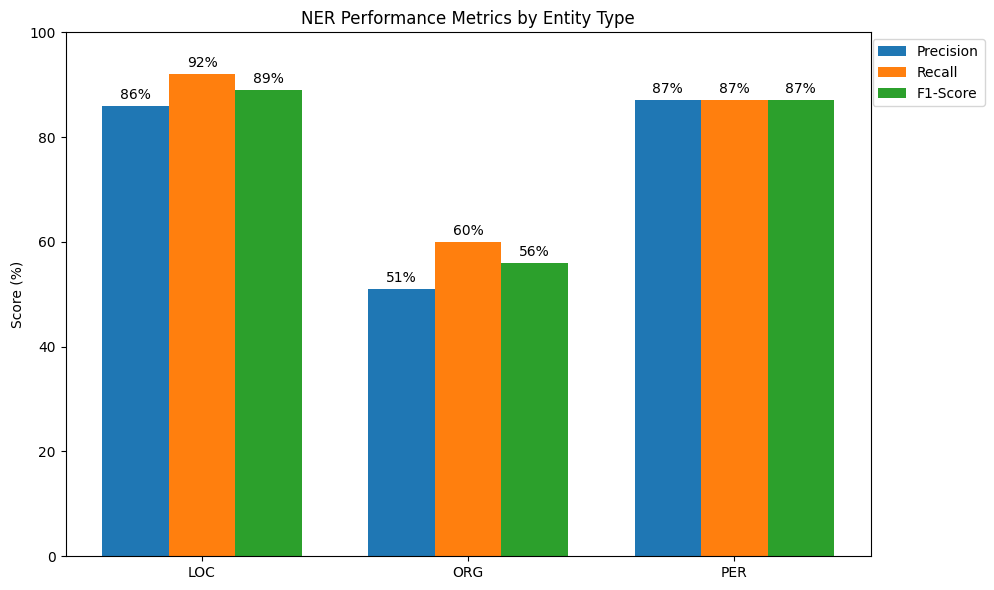

In [87]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['LOC', 'ORG', 'PER']
metrics = ['Precision', 'Recall', 'F1-Score']
data = np.array([
    [86, 92, 89],  # LOC
    [51, 60, 56],  # ORG
    [87, 87, 87]   # PER
])

x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, data[:, i], width, label=metric)

ax.set_ylabel('Score (%)')
ax.set_title('NER Performance Metrics by Entity Type')
ax.set_xticks(x + width)
ax.set_xticklabels(categories)
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
ax.set_ylim(0, 100)

for i in range(len(categories)):
    for j in range(len(metrics)):
        height = data[i, j]
        ax.annotate(f'{height}%',
                    xy=(x[i] + j*width, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
#  модель на GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

NERModel_4(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a